In [1]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline # for plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
# data_path = 'data/financial_data/USD_INR.csv'
data_path = 'data/bike_data/hour.csv'
data = pd.read_csv(data_path)

# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# Showing the data file csv or comma separated value
data[:10]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


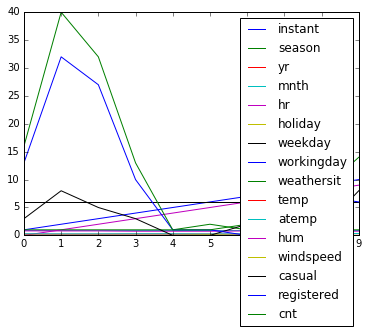

In [2]:
# # Plotting the smartwatch data before scaling/batch normalization
# data[:10000]['Price'].plot()
data[: 10].plot()
plt.legend()
plt.show()

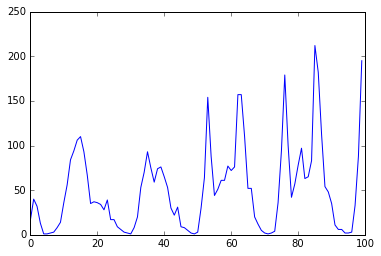

In [3]:
data_array = np.array(data)
data_array.shape, data_array.dtype
data_main = np.array(data_array[:, -1:], dtype=float)
data_main.shape, data_main.dtype

plt.plot(data_main[:100])
plt.show()

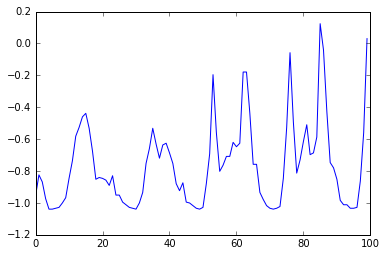

(-1.0548364452851478e-16, 1.0, 1.0, (17379, 1), dtype('float64'))

In [4]:
mean = np.mean(data_main, axis=0)
std = np.std(data_main, axis=0)
std.shape, mean.shape, std.dtype, mean.dtype

data_norm = (data_main - mean) / std
plt.plot(data_norm[:100])
plt.show()
data_norm.mean(), data_norm.std(), data_norm.var(), data_norm.shape, data_norm.dtype

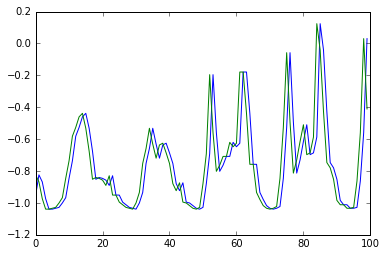

In [5]:
train_data = data_norm[:16000] # the last dim/variable/feature
test_data = data_norm[16000:] # the last dim/variable/feature
train_data.shape, test_data.shape
X_train = train_data[0:15999]
Y_train = train_data[1:16000]
X_train.shape, Y_train.shape

plt.plot(X_train[:100])
plt.plot(Y_train[:100])
plt.show()

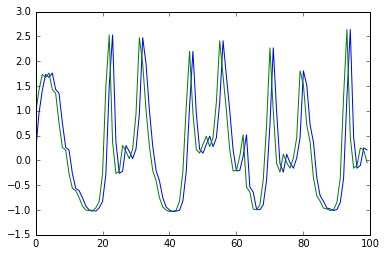

In [6]:
X_valid = test_data[0:1378] 
Y_valid = test_data[1:1379]
X_valid.shape, Y_valid.shape
plt.plot(X_valid[:100])
plt.plot(Y_valid[:100])
plt.show()

In [7]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, p_dropout):
        self.D = D
        self.H = H
        self.p_dropout = p_dropout
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = m
        
    def initial_state(self):
        return np.zeros((1, self.H))
    
    # The original implementatopn of forward pass 
    def forward(self, X_one_hot, h_old, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X = np.column_stack((h_old, X_one_hot))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X_prime = np.column_stack((hr * h_old, X_one_hot))
        hh, hh_cache = l.fc_forward(X_prime, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = (1. - hz) * h_old + hz * hh

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (
            X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache,
            hh, hh_cache, hh_tanh_cache, h, y_cache
        )

        return y, h, cache

    # The original implementatopn of backward pass 
    def backward(self, dy, dh_next, cache):
        X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, h, y_cache = cache

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next

        dhh = hz * dh
        dh_old1 = (1. - hz) * dh
        dhz = hh * dh - h_old * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dX_prime, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh_prime = dX_prime[:, :self.H]
        dh_old2 = hr * dh_prime

        dhr = h_old * dh_prime
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_old3 = dX[:, :self.H]

        dh_next = dh_old1 + dh_old2 + dh_old3

        grads = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)

        return dX, dh_next, grads

    def train_forward(self, X_train, h):
        ys, fc_caches, do_caches = [], [], []

        for X in X_train:
            X = X.reshape(1, -1) # X_1xn
            y, h, fc_cache = self.forward(X, h, self.model)
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            fc_caches.append(fc_cache)
            do_caches.append(do_cache)
            ys.append(y)
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        caches = (fc_caches, do_caches)
        
        return ys, caches
                                
    def loss_function(self, y_pred, y_train): # , alpha alpha: learning rate
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression(y_pred=y, y_train=Y)
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        fc_caches, do_caches = caches
        
        dh = np.zeros((1, self.H)) 
        grad = {key: np.zeros_like(val) for key, val in self.model.items()}
        grads= {key: np.zeros_like(val) for key, val in self.model.items()}

        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dy = l.dropout_backward(dy, do_caches[t])
            dX, dh, grad = self.backward(dy, dh, fc_caches[t])
            for key in grad.keys():
                grads[key] += grad[key]
                
        return dX, grads
    
    def test(self, X_seed, h, size):
        ys = []
        X = X_seed.reshape(1, -1)
        for _ in range(size):
            y, h, _ = self.forward(X, h, self.model)
            X = y.copy() # previous out for the next input for prediction
            ys.append(y) # list array
        
        ys = np.array(ys, dtype=float).reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        return ys

In [8]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:(i + minibatch_size)]
        y_mini = y[i:(i + minibatch_size)]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, XY_valid, alpha, mb_size, n_iter, print_after):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid

    # Momentum
    M= {key: np.zeros_like(val) for key, val in nn.model.items()}
    R= {key: np.zeros_like(val) for key, val in nn.model.items()}
    
    # Learning decay: suggested by Justin Jhonson in Standford
    beta1 = .9
    beta2 = .99
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    # Epochs: iterating through the whole data
    for iter in range(1, n_iter + 1):
        
        # Minibatches
        for idx in range(len(minibatches)):
            
            # Train the model
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini) #, alpha=alpha
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Update the model
            for key in grads.keys(): #key, value: items
                M[key] = l.exp_running_avg(M[key], grads[key], beta1)
                R[key] = l.exp_running_avg(R[key], grads[key]**2, beta2)
                m_k_hat = M[key] / (1. - (beta1** iter))
                r_k_hat = R[key] / (1. - (beta2** iter))
                nn.model[key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the model (by testing)
            ys = nn.test(X_seed=X_valid[0], h=state, size=X_valid.shape[0]) # ys_tx1xn
            valid_loss, _ = nn.loss_function(y_pred=ys, y_train=Y_valid) #, alpha=alpha
            nn.losses['valid'].append(valid_loss)

        # Print the model loss/ error
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.8f}, valid loss: {:.8f}'.format(iter, loss, valid_loss))

    return nn

In [ ]:
# Hyper-parameters
time_step = 64 # minibatch size: 32, 64, 128, or 256 Cache
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate: 1e-3, 5e-4, 1e-4 - default choices
print_after = 1 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = X_train.shape[1] # X_txn: noise given by using all possible channels/ features
keep_prob = 0.95 # p_dropout == keep_prob: keeping neurons/units function - default 0.95 to 0.9 based on SELU-Dropout

# Build the network and learning it or optimizing it using SGD
# def adam_rnn(nn, X_train, y_train, alpha=0.001, mb_size=256, n_iter=2000, print_after=100):
net = GRU(D=num_input_units, H=num_hidden_units, p_dropout=keep_prob) # , lam=lam, L=num_layers, p_dropout=p_dropout

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=(X_train, Y_train), XY_valid=(X_valid, Y_valid), alpha=alpha, mb_size=time_step,
         n_iter=n_iter, print_after=print_after)

Iter-1, train loss: 30.70212305, valid loss: 632.91934660
Iter-2, train loss: 30.17579575, valid loss: 632.69786171
Iter-3, train loss: 30.08744097, valid loss: 635.27840650
Iter-4, train loss: 30.40181628, valid loss: 666.14573646
Iter-5, train loss: 30.00232400, valid loss: 752.34526715
Iter-6, train loss: 29.86732310, valid loss: 880.12281004
Iter-7, train loss: 28.30336806, valid loss: 832.42841871
Iter-8, train loss: 29.79148862, valid loss: 802.08941679
Iter-9, train loss: 29.84220890, valid loss: 868.66371282
Iter-10, train loss: 29.90412142, valid loss: 963.53426846
Iter-11, train loss: 30.71756957, valid loss: 916.34512439
Iter-12, train loss: 29.74213918, valid loss: 1004.43192182
Iter-13, train loss: 30.46093117, valid loss: 1400.09933846
Iter-14, train loss: 30.05437331, valid loss: 986.75113477
Iter-15, train loss: 30.58753627, valid loss: 1298.61669066
Iter-16, train loss: 30.55212958, valid loss: 1047.62877607
Iter-17, train loss: 30.71198905, valid loss: 1073.92001897
I

Iter-138, train loss: 30.02162449, valid loss: 1538.86072327
Iter-139, train loss: 29.93958947, valid loss: 781.93737682
Iter-140, train loss: 30.50808574, valid loss: 1343.07667424
Iter-141, train loss: 29.53295214, valid loss: 1350.53491163
Iter-142, train loss: 28.40705856, valid loss: 1076.70177346
Iter-143, train loss: 25.65958682, valid loss: 1455.49841609
Iter-144, train loss: 30.06716674, valid loss: 987.56768717
Iter-145, train loss: 29.96990622, valid loss: 1012.88071788
Iter-146, train loss: 29.10914134, valid loss: 1303.12525153
Iter-147, train loss: 29.05136819, valid loss: 1256.58704500
Iter-148, train loss: 26.83495637, valid loss: 848.59868213
Iter-149, train loss: 28.57819678, valid loss: 1164.57081678
Iter-150, train loss: 29.67036948, valid loss: 1282.66753114
Iter-151, train loss: 30.21313948, valid loss: 968.56901497
Iter-152, train loss: 28.74430456, valid loss: 1244.70778137
Iter-153, train loss: 30.04886164, valid loss: 1043.42671808
Iter-154, train loss: 30.412

Iter-274, train loss: 29.77014303, valid loss: 744.54688333
Iter-275, train loss: 28.41086052, valid loss: 1418.65588848
Iter-276, train loss: 28.40671026, valid loss: 1022.75565523
Iter-277, train loss: 30.19682612, valid loss: 822.73830613
Iter-278, train loss: 27.82315563, valid loss: 1121.51437013
Iter-279, train loss: 29.17329637, valid loss: 1216.60675998
Iter-280, train loss: 30.27974121, valid loss: 924.10978252
Iter-281, train loss: 30.37357494, valid loss: 871.05607936
Iter-282, train loss: 30.18428896, valid loss: 897.01280143
Iter-283, train loss: 30.30958609, valid loss: 838.06096674
Iter-284, train loss: 30.15239621, valid loss: 809.69915164
Iter-285, train loss: 29.59630148, valid loss: 1586.49301269
Iter-286, train loss: 30.53289899, valid loss: 882.21202786
Iter-287, train loss: 30.80174536, valid loss: 738.84760839
Iter-288, train loss: 30.13730363, valid loss: 996.05016607
Iter-289, train loss: 27.55453067, valid loss: 808.31581455
Iter-290, train loss: 30.06230087, 

Iter-410, train loss: 30.49830499, valid loss: 1270.10924953
Iter-411, train loss: 27.27679173, valid loss: 1028.28429480
Iter-412, train loss: 29.05101358, valid loss: 995.92846936
Iter-413, train loss: 28.92701101, valid loss: 1054.85973365
Iter-414, train loss: 30.40566469, valid loss: 1165.52742228
Iter-415, train loss: 30.72152084, valid loss: 987.20334111
Iter-416, train loss: 30.78931562, valid loss: 1381.27468063
Iter-417, train loss: 30.27864463, valid loss: 1092.99080676
Iter-418, train loss: 28.13420150, valid loss: 1184.97114748
Iter-419, train loss: 28.95174598, valid loss: 1153.91504394
Iter-420, train loss: 30.18638923, valid loss: 1094.80383998
Iter-421, train loss: 30.07481692, valid loss: 1068.75150177
Iter-422, train loss: 28.89286424, valid loss: 1217.72229614
Iter-423, train loss: 29.54142814, valid loss: 914.32344869
Iter-424, train loss: 29.60236539, valid loss: 808.23949761
Iter-425, train loss: 29.58899892, valid loss: 835.96102921
Iter-426, train loss: 30.5327

Iter-546, train loss: 30.31261561, valid loss: 959.56606623
Iter-547, train loss: 28.66922265, valid loss: 962.27207076
Iter-548, train loss: 30.78931562, valid loss: 999.07035519
Iter-549, train loss: 30.12270801, valid loss: 1354.65105839
Iter-550, train loss: 28.90157437, valid loss: 1075.10260622
Iter-551, train loss: 30.38966265, valid loss: 1184.52122186
Iter-552, train loss: 30.30422556, valid loss: 1147.32425549
Iter-553, train loss: 29.96884148, valid loss: 1148.42721888
Iter-554, train loss: 30.35800940, valid loss: 1147.49212739
Iter-555, train loss: 30.11783428, valid loss: 1215.14435901
Iter-556, train loss: 29.76509881, valid loss: 1029.55655300
Iter-557, train loss: 29.71808082, valid loss: 1096.11049817
Iter-558, train loss: 30.78931562, valid loss: 1010.40617781
Iter-559, train loss: 29.12028766, valid loss: 1086.60493282
Iter-560, train loss: 29.54641817, valid loss: 1035.20764706
Iter-561, train loss: 27.72924630, valid loss: 1129.94545306
Iter-562, train loss: 26.12

In [ ]:
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

y_pred = net.test(X_seed=X_valid[0], h=net.initial_state(), size=X_valid.shape[0]) # ys_tx1xn
y_pred.shape, Y_valid.shape

plt.plot(y_pred[:200, :], label='y_pred')
plt.plot(Y_valid[:200, :], label='Y_valid')
# plt.plot(X_valid[:100], label='X_valid')
plt.legend()
plt.show()